# Exploring and pre processing the dataset

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

I have choosen only upper/full body cloths due to time and resource constrains.

Moreover to make a balanced dataset I have rejected those categories for which number of samples is less than 2000, and I have taken maximum of 7000 images per category in the training set though the "database" include all images of the category

['Blazer', 'Cardigan', 'Hoodie', 'Jacket', 'Sweater', 'Tank', 'Tee', 'Top', 'Dress', 'Jumpsuit', 'Romper']
Number of images avaliable for train/val: 64806
Number of images avaliable in database: 139734
Number of categories: 11


<AxesSubplot:title={'center':'Number of samples per category'}>

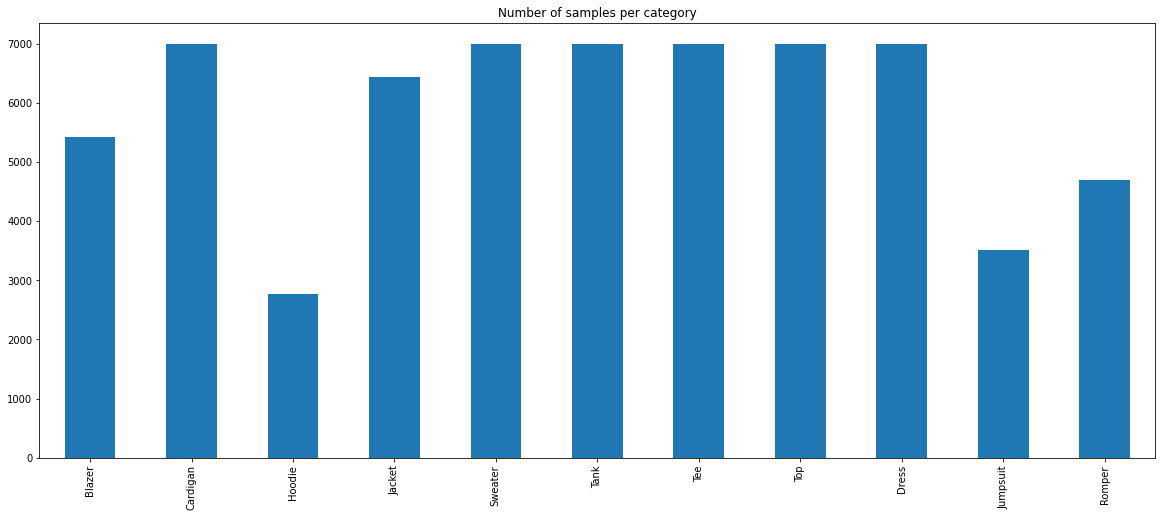

In [21]:
# load the label vs image data
base_path = "../dataset/"
path = "../dataset/anno/list_category_img.txt"
labels = pd.read_csv(path, sep=',', engine = 'python')

# _________________________________________________________________________________________________________________#
# load the label names

label_name = pd.read_csv('../dataset/anno/list_category_cloth.txt', sep='        ',engine='python')
cloth_type =  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
label_list  = []
for x in label_name.index:
    if x[-1].isnumeric():
        label_list.append(x[:-1].strip())
    else:
        label_list.append(x)
# _________________________________________________________________________________________________________________#
# Take only those categories whose number of samples are greater than 2000, take max of 7000 samples. Remove lower body clothes and "blouse" which is similar to "top"

upp_bound = 7000
lower_bound = 2000

cats = labels.groupby(labels['category_label'])
train_data = pd.DataFrame(columns=labels.columns)
total_database = pd.DataFrame(columns=labels.columns)

for c in cats.groups:
    id = int(c-1)
    if cloth_type[id] == 2 or label_list[id].lower() == 'blouse':
        continue
    data = cats.get_group(c)
    if len(data) < lower_bound:
        continue
    elif len(data) > upp_bound:
        train_data = train_data.append(data.sample(n=upp_bound, random_state=42))
    else:
        train_data = train_data.append(data)
    total_database = total_database.append(data)


# _________________________________________________________________________________________________________________#
# create new labels and label_map

new_count = train_data['category_label'].value_counts().sort_index()
new_labels = []
i=0
for x in new_count.index:
    j = int(x)-1
    new_labels.append(label_list[j])
    train_data['category_label'].replace(x,i,inplace=True)
    total_database['category_label'].replace(x,i,inplace=True)
    i+=1
train_data['category_label'] = train_data['category_label'].astype(int)
total_database['category_label'] = total_database['category_label'].astype(int)

# _________________________________________________________________________________________________________________#
# show final stats

print(new_labels)
print("Number of images avaliable for train/val:",train_data.shape[0])
print("Number of images avaliable in database:",total_database.shape[0])
print("Number of categories:",len(new_labels))


new_count = train_data['category_label'].value_counts().sort_index()
new_count.index = new_labels
plt.figure(figsize=(20,8))
plt.title('Number of samples per category')
new_count.plot(kind='bar')

# Some sample images from database

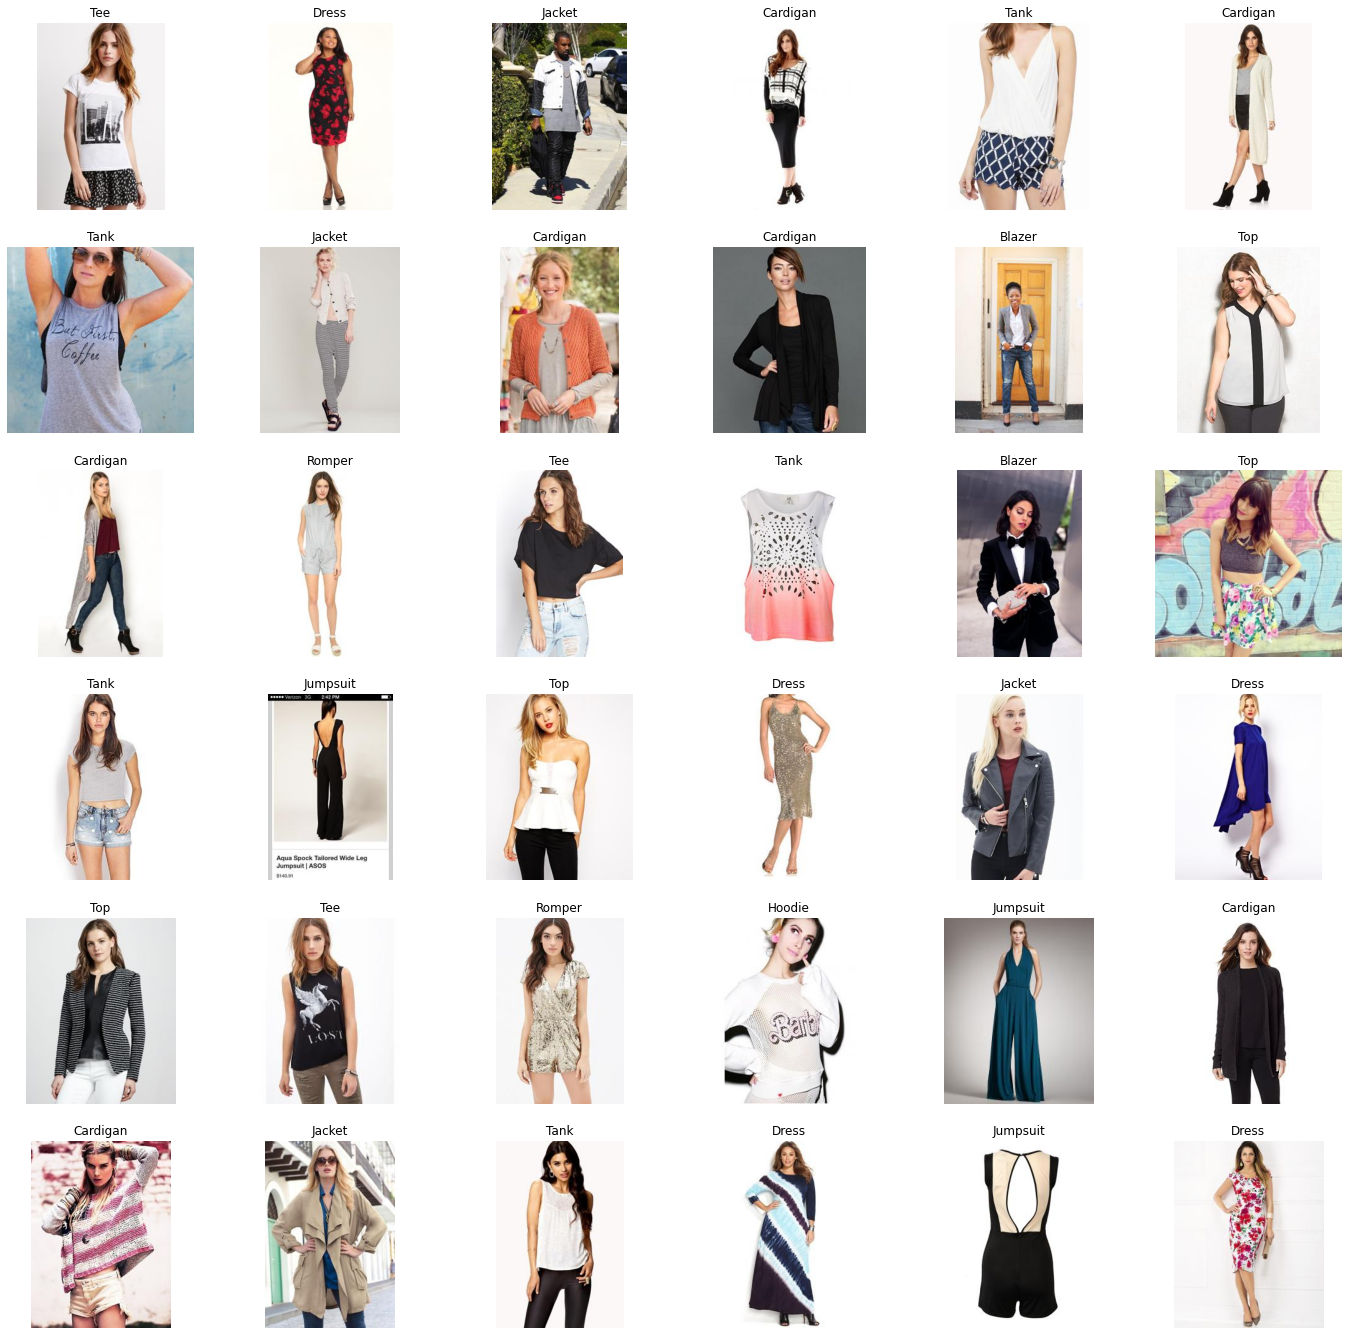

In [23]:
# Some sample images
train_data = train_data.sample(frac=1).reset_index(drop=True)
n_samples = 6
plt.figure(figsize=(n_samples*4,n_samples*4))
for i in range(n_samples*n_samples):
    img_path = train_data.iloc[i]['image_name']
    category = new_labels[train_data.iloc[i]['category_label']]
    plt.subplot(n_samples,n_samples,i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(category)
    plt.axis('off')

plt.show()

In [24]:
# save the data
train_data.to_csv('../dataset/anno/img_label2.csv', sep=',', index=False)
total_database.to_csv('../dataset/anno/img_label_database2.csv', sep=',', index=False)

with  open('../dataset/anno/label_map2.txt', 'w') as f:
    f.write('\n'.join(new_labels))